In [4]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download -d oddrationale/mnist-in-csv if not in competition
!kaggle competitions download -c dogs-vs-cats

Saving kaggle.json to kaggle.json
100% 810M/812M [00:04<00:00, 38.7MB/s]
100% 812M/812M [00:04<00:00, 192MB/s] 


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import random
import tensorflow as tf


from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile



In [6]:
!unzip /content/dogs-vs-cats.zip

Archive:  /content/dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [7]:
!unzip /content/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

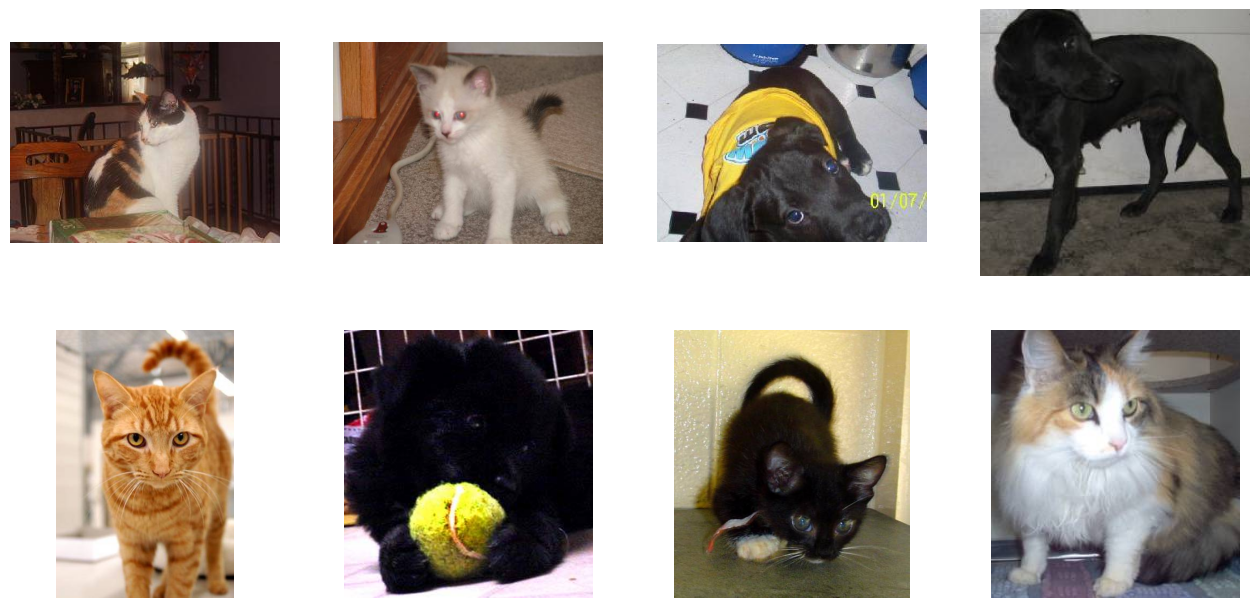

In [8]:
import matplotlib.image as mpimg
plt.figure(figsize=(16,16))
images = os.listdir('/content/train')
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join('/content/train',img))
    fig.imshow(img)

In [9]:
try:
    parent_dir = '/content/cats-v-dogs'
    os.mkdir(parent_dir)
    for dir in ['training','validation']:
        path = os.path.join(parent_dir,dir)
        os.mkdir(path)
        for dir in ['cats','dogs']:
            n_path = os.path.join(path,dir)
            os.mkdir(n_path)
except OSError:
    print("Existed")



In [10]:
src_dir = '/content/train'

cats_train_dir ='/content/cats-v-dogs/training/cats'
cats_valid_dir ='/content/cats-v-dogs/validation/cats'

dogs_train_dir ='/content/cats-v-dogs/training/dogs'
dogs_valid_dir ='/content/cats-v-dogs/validation/dogs'
cats = [img for img in os.listdir(src_dir) if img[:3]=='cat']
dogs = [img for img in os.listdir(src_dir) if img[:3]=='dog']
# Take 10% of training images for validation
cats_valid_sample = random.sample(cats,int(0.1*len(cats)))
dogs_valid_sample = random.sample(dogs,int(0.1*len(dogs)))

In [11]:
import shutil
for img in os.listdir(src_dir):
    src_img = os.path.join(src_dir, img)

    if img[:3] == 'cat':
        if img in cats_valid_sample:
            dest_img = os.path.join(cats_valid_dir, img)
        else:
            dest_img = os.path.join(cats_train_dir, img)

    elif img[:3] == 'dog':
        if img in dogs_valid_sample:
            dest_img = os.path.join(dogs_valid_dir, img)
        else:
            dest_img = os.path.join(dogs_train_dir, img)
    if not os.path.exists(dest_img):
        shutil.copyfile(src_img, dest_img)

In [12]:
print('No. of ALL cats : ', len(cats))
print('No. of cats for training: ', len(os.listdir(cats_train_dir)))
print('No. of cats for validation: ', len(os.listdir(cats_valid_dir)))

print('\nNo. of ALL dogs : ', len(dogs))
print('No. of dogs for training: ', len(os.listdir(dogs_train_dir)))
print('No. of dogs for validation: ', len(os.listdir(dogs_valid_dir)))

No. of ALL cats :  12500
No. of cats for training:  11250
No. of cats for validation:  1250

No. of ALL dogs :  12500
No. of dogs for training:  11250
No. of dogs for validation:  1250


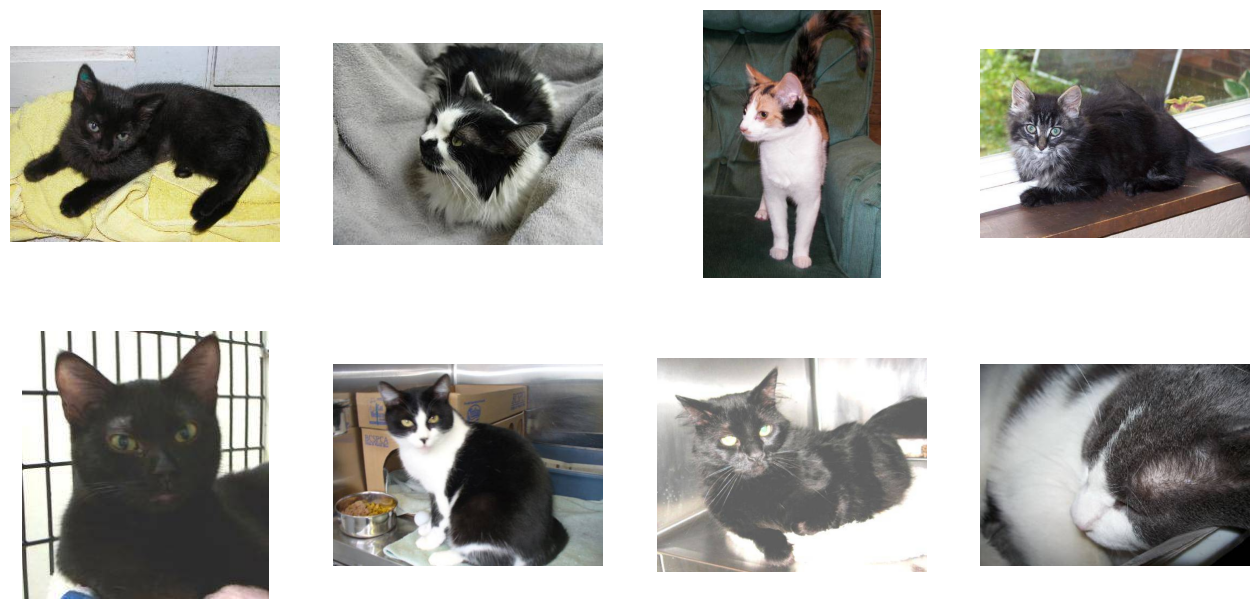

In [13]:
plt.figure(figsize=(16,16))

images = os.listdir(cats_train_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(cats_train_dir, img))
    fig.imshow(img)

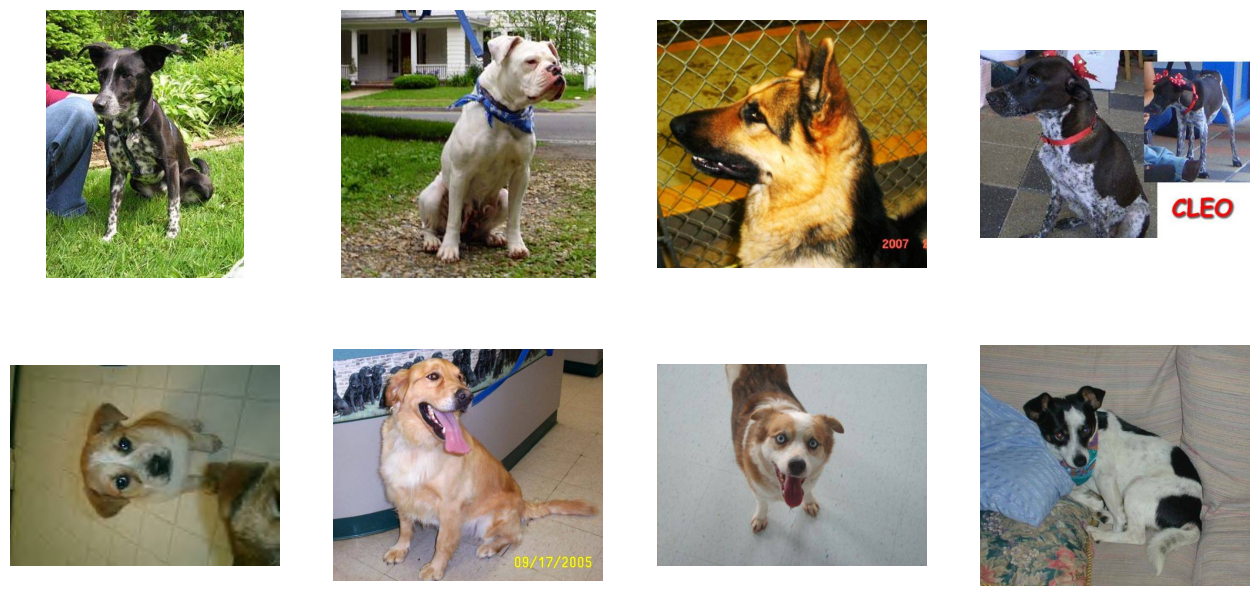

In [14]:
plt.figure(figsize=(16,16))

images = os.listdir(dogs_train_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(dogs_train_dir, img))
    fig.imshow(img)

In [15]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)

train_dir = '/content/cats-v-dogs/training'
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150,150),
                                                    batch_size =32,class_mode='binary')

valid_dir = '/content/cats-v-dogs/validation'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150,150),
                                                    batch_size =32,class_mode='binary')



Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [16]:
print(valid_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [17]:
model = Sequential([
    Conv2D(32,(3,3),activation ='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64,(3,3),activation ='relu'),
    MaxPooling2D(2,2),
    Conv2D(128,(3,3),activation ='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128,activation='relu'),
    Dense(1,activation='sigmoid')])
model.compile(optimizer='adamax',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(train_generator,epochs=5,validation_data=valid_generator)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.6075 - loss: 0.6830 - val_accuracy: 0.7352 - val_loss: 0.5323
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.7665 - loss: 0.4869 - val_accuracy: 0.7668 - val_loss: 0.4854
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.8026 - loss: 0.4254 - val_accuracy: 0.8004 - val_loss: 0.4257
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.8304 - loss: 0.3793 - val_accuracy: 0.7992 - val_loss: 0.4250
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.8597 - loss: 0.3260 - val_accuracy: 0.8056 - val_loss: 0.4135


In [19]:
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(valid_generator)[1]
print('Train Accuracy: ',train_acc)
print('Validation Accuracy: ',valid_acc)

704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.8809 - loss: 0.2800
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8125 - loss: 0.4071
Train Accuracy:  0.879111111164093
Validation Accuracy:  0.8055999875068665


# Data Augmentation

* Increase the diversity of your training set by applying random (but realistict) ransformations, such as image rotation

*   Enlarge dataset

*   Avoid Overfitting




In [20]:
aug_train_datagen = ImageDataGenerator(rescale =1./255,
                                       rotation_range=90,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1/255)
train_dir = '/content/cats-v-dogs/training'
aug_train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150,150),
                                                    batch_size =32,class_mode='binary')
valid_dir = '/content/cats-v-dogs/validation'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150,150),
                                                    batch_size =32,class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [21]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('/content/weights.best.keras', monitor='val_loss', save_best_only=True)]


# create model
aug_model = Sequential([    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                            MaxPooling2D(2, 2),
                            Conv2D(64, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Conv2D(128, (3,3), activation='relu'),
                            MaxPooling2D(2,2),

                            Flatten(),
                            Dense(128, activation='relu'),
                            Dense(1, activation='sigmoid')  ])

# load weights if exists
if os.path.exists("/content/weights.best.hdf5"):
    aug_model.load_weights("weights.best.hdf5")

# Compile model
aug_model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
aug_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
aug_history = aug_model.fit(aug_train_generator, epochs=5, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)


Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.5817 - loss: 0.6742 - val_accuracy: 0.7324 - val_loss: 0.5349
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 56ms/step - accuracy: 0.7508 - loss: 0.5100 - val_accuracy: 0.7728 - val_loss: 0.4676
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.7930 - loss: 0.4482 - val_accuracy: 0.7992 - val_loss: 0.4445
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.8151 - loss: 0.3990 - val_accuracy: 0.8112 - val_loss: 0.3993
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.8445 - loss: 0.3514 - val_accuracy: 0.8152 - val_loss: 0.4187


In [23]:
train_acc = aug_model.evaluate(train_generator)[1]
valid_acc = aug_model.evaluate(valid_generator)[1]
print("Our Augmented Base Model Accuracy on Training Data: ", train_acc)
print("Our Augmented Base Model Accuracy on Validation Data: ", valid_acc)
# Still Overfitting
# We may try more Regularization

704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8612 - loss: 0.3309
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8082 - loss: 0.4318
Our Augmented Base Model Accuracy on Training Data:  0.8611111044883728
Our Augmented Base Model Accuracy on Validation Data:  0.8151999711990356


In [24]:
from keras.regularizers import l2

my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('/content/weights2.best.keras', monitor='val_loss', save_best_only=True)]

# create model
new_model = Sequential([    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                            MaxPooling2D(2, 2),
                            Conv2D(64, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Conv2D(128, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Conv2D(128, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Flatten(),
                            BatchNormalization(),
                            Dense(128, kernel_regularizer = l2(0.15), bias_regularizer=l2(0.15), activation='relu'),
                            Dropout(rate = 0.5 , seed = 40),
                            Dense(1, activation='sigmoid')  ])

# load weights if exists
if os.path.exists("/content/weights2.best.keras"):
    new_model.load_weights("weights2.best.keras")

# Compile model
new_model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6272)           │        25,088 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,068,993 (4.08 MB)

 Trainable params: 1,056,449 (4.03 MB)

 Non-trainable params: 12,544 (49.00 KB)

In [25]:
new_history = new_model.fit(aug_train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)


Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 49s 62ms/step - accuracy: 0.6630 - loss: 4.6833 - val_accuracy: 0.7308 - val_loss: 0.6354
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.7888 - loss: 0.5525 - val_accuracy: 0.8196 - val_loss: 0.5087
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.8288 - loss: 0.4935 - val_accuracy: 0.7792 - val_loss: 0.5581
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.8497 - loss: 0.4538 - val_accuracy: 0.7988 - val_loss: 0.5429
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.8587 - loss: 0.4359 - val_accuracy: 0.8664 - val_loss: 0.4226
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.8778 - loss: 0.4010 - val_accuracy: 0.8832 - val_loss: 0.3947
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.8927 - loss: 0.3698 - val_accuracy: 0.8676 - val_loss: 0.3996
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9096 - loss: 0.3341 - 

In [26]:
train_acc = new_model.evaluate(train_generator)[1]
valid_acc = new_model.evaluate(valid_generator)[1]
print("Our New Model Accuracy on Training Data: ", train_acc)
print("Our New Model Accuracy on Validation Data: ", valid_acc)

704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.9777 - loss: 0.1836
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9038 - loss: 0.3823
Our New Model Accuracy on Training Data:  0.9791111350059509
Our New Model Accuracy on Validation Data:  0.9071999788284302


In [27]:
new_history = new_model.fit(aug_train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)


Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.9689 - loss: 0.1877 - val_accuracy: 0.8072 - val_loss: 0.6867
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9705 - loss: 0.1784 - val_accuracy: 0.8940 - val_loss: 0.3692
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.9741 - loss: 0.1702 - val_accuracy: 0.8384 - val_loss: 0.5682
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.9765 - loss: 0.1551 - val_accuracy: 0.9140 - val_loss: 0.3501
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.9798 - loss: 0.1506 - val_accuracy: 0.9096 - val_loss: 0.3598
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9779 - loss: 0.1545 - val_accuracy: 0.8856 - val_loss: 0.4712
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.9824 - loss: 0.1348 - val_accuracy: 0.9240 - val_loss: 0.2985
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.9845 - loss: 0.1168 - 

In [28]:
train_acc = new_model.evaluate(train_generator)[1]
valid_acc = new_model.evaluate(valid_generator)[1]
print("Our New Model Accuracy on Training Data: ", train_acc)
print("Our New Model Accuracy on Validation Data: ", valid_acc)

704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.9978 - loss: 0.0915
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9316 - loss: 0.2975
Our New Model Accuracy on Training Data:  0.9980000257492065
Our New Model Accuracy on Validation Data:  0.9228000044822693


# Transfer Learning

A technique where knowledge learned from a task is re-used in order to boost performance on a related task.

The pre-trained models are usually trained on massive datasets that are a standard benchmark. The weights obtained from the models can be reused in other tasks.

Transfer learning is particularly very useful when you have a small training dataset.

In [29]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-06-28 23:44:33--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content//inception 100%[===================>]  83.84M   159MB/s    in 0.5s    

2025-06-28 23:44:33 (159 MB/s) - ‘/content//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [30]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [31]:
pre_trained_model.summary()


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 74, 74,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │         96 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 35, 35,    │      5,120 │ max_pooling2d_10… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [33]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [34]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 74, 74,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │         96 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 35, 35,    │      5,120 │ max_pooling2d_10… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [35]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [37]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('content/weights_tf.best.keras', monitor='val_loss', save_best_only=True)]

# Train the model.
history = model.fit(aug_train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 69s 81ms/step - accuracy: 0.9360 - loss: 0.1763 - val_accuracy: 0.9596 - val_loss: 0.0962
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.9836 - loss: 0.0429 - val_accuracy: 0.9592 - val_loss: 0.1106
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.9934 - loss: 0.0202 - val_accuracy: 0.9692 - val_loss: 0.1095
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.9672 - val_loss: 0.1146
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0.9684 - val_loss: 0.1237
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.9998 - loss: 9.0126e-04 - val_accuracy: 0.9672 - val_loss: 0.1333


704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 1.0000 - loss: 3.1451e-04
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9692 - loss: 0.1176
Transfer Learning Model Accuracy on Training Data:  0.9999111294746399
Transfer Learning Model Accuracy on Validation Data:  0.967199981212616


<Axes: >

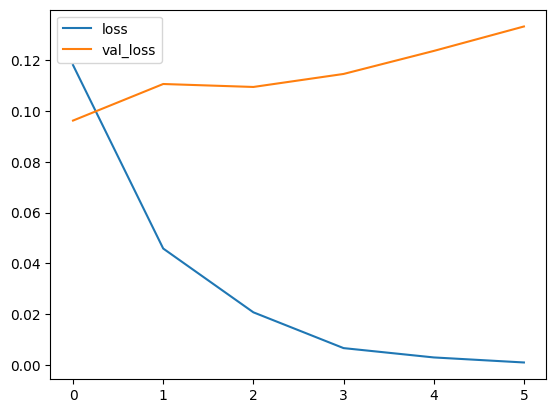

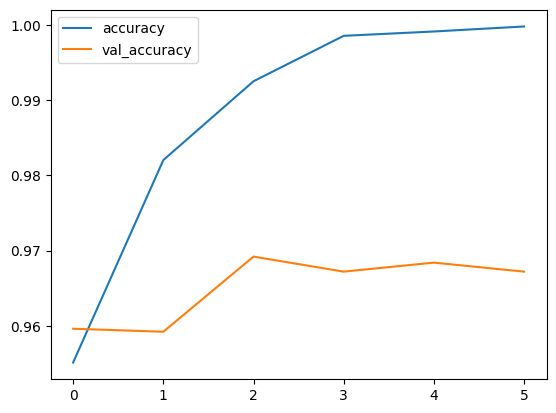

In [38]:
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(valid_generator)[1]
print("Transfer Learning Model Accuracy on Training Data: ", train_acc)
print("Transfer Learning Model Accuracy on Validation Data: ", valid_acc)
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()